In [2]:
random_state = 42 # notebook consistency

from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

from tqdm import tqdm
import time

from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

## Load data
cwd = os.getcwd()
os.chdir('..')
from scripts.consensus_matrix import *
from scripts.utils import *
df = pd.read_csv('BRCA_data.csv')

os.chdir(cwd)

sample_name = df.iloc[:,0].copy()    # sample index
X = df.iloc[:,1:354].copy()          # X : gene expression features
y = df.iloc[:,354:].copy()           # y : clinical labels

## Part A

In [3]:
umap_model = UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    random_state=random_state,
    n_jobs=1
)
X_umap = make_pipeline(umap_model).fit_transform(X)

# scaler = StandardScaler()
# tsne_model = TSNE(
#     n_components=2,
#     perplexity=30,
#     learning_rate=50,
#     init='random',
#     metric='euclidean',
#     random_state=random_state,
#     max_iter=1000,
# )
# X_tsne = make_pipeline(scaler, tsne_model).fit_transform(X)

tsne_model = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=50,
    init='random',
    metric='euclidean',
    random_state=random_state,
    max_iter=1000,
)
X_tsne = make_pipeline(tsne_model).fit_transform(X)

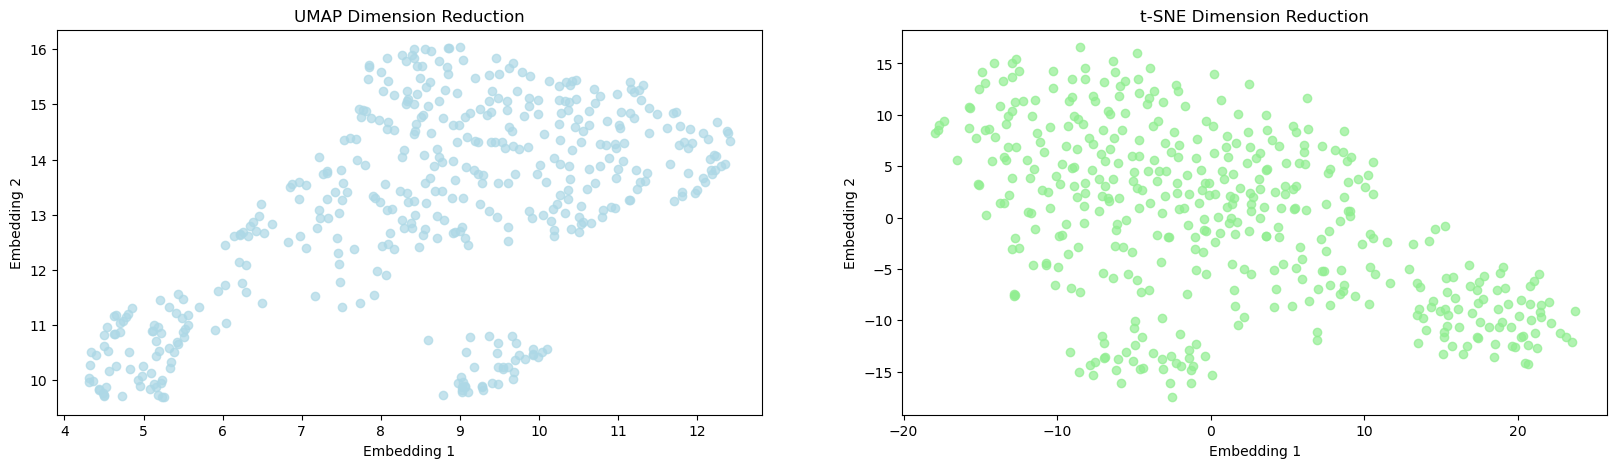

In [4]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].scatter(X_umap[:,0],X_umap[:,1], color='lightblue', alpha=0.7)
ax[0].set_title('UMAP Dimension Reduction')
ax[0].set_xlabel('Embedding 1')
ax[0].set_ylabel('Embedding 2')

ax[1].scatter(X_tsne[:,0],X_tsne[:,1], color='lightgreen', alpha=0.7)
ax[1].set_title('t-SNE Dimension Reduction')
ax[1].set_xlabel('Embedding 1')
ax[1].set_ylabel('Embedding 2')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


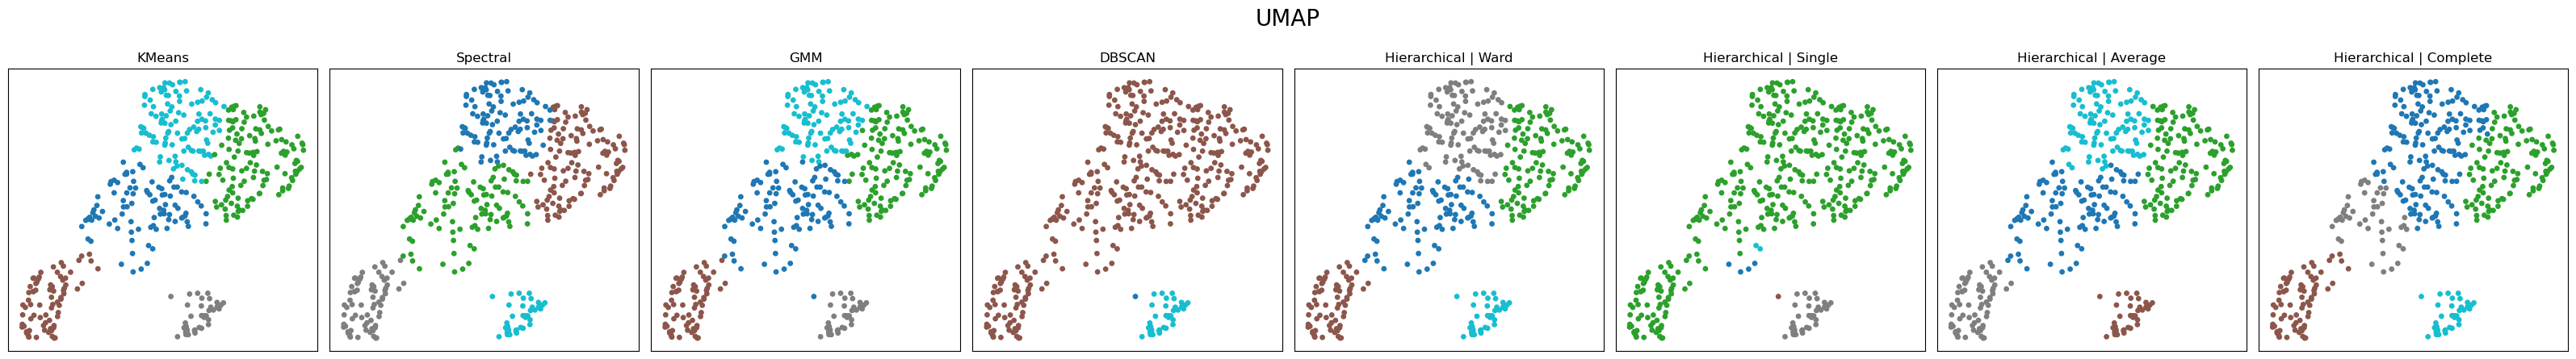

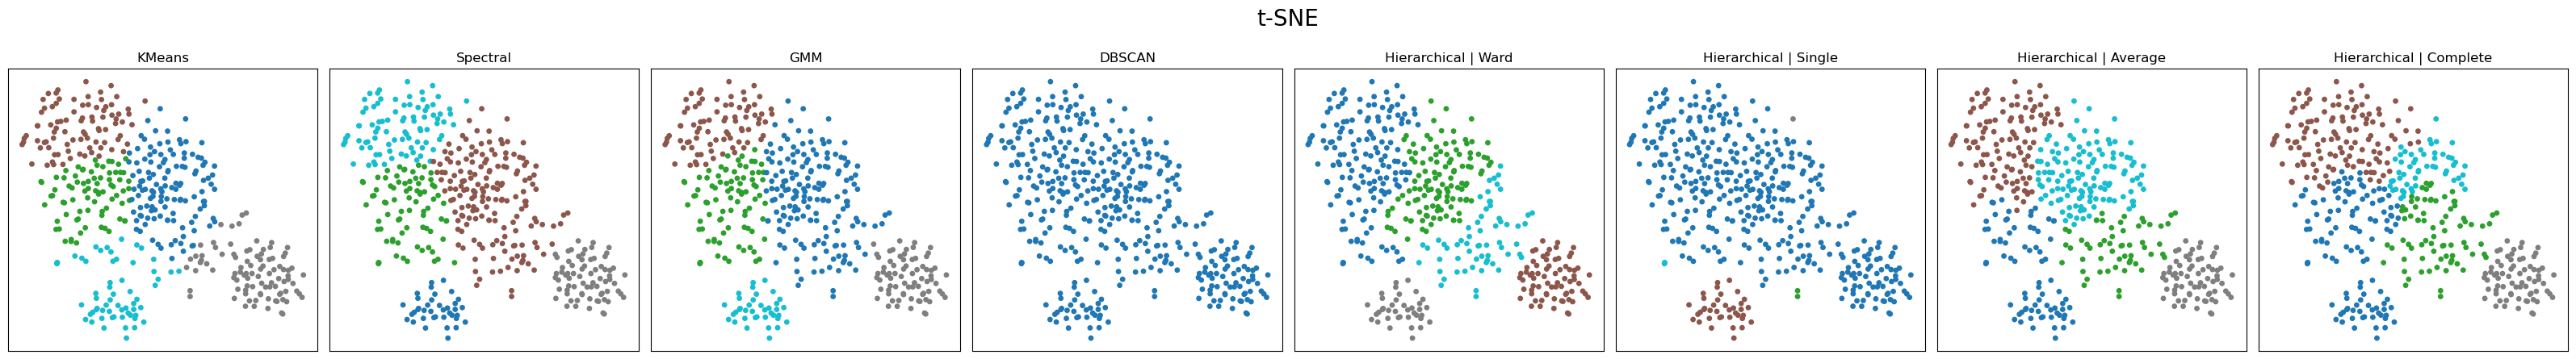

In [5]:
plot_results(*create_cluster_dict(X_umap), title='UMAP')
plot_results(*create_cluster_dict(X_tsne), title='t-SNE')

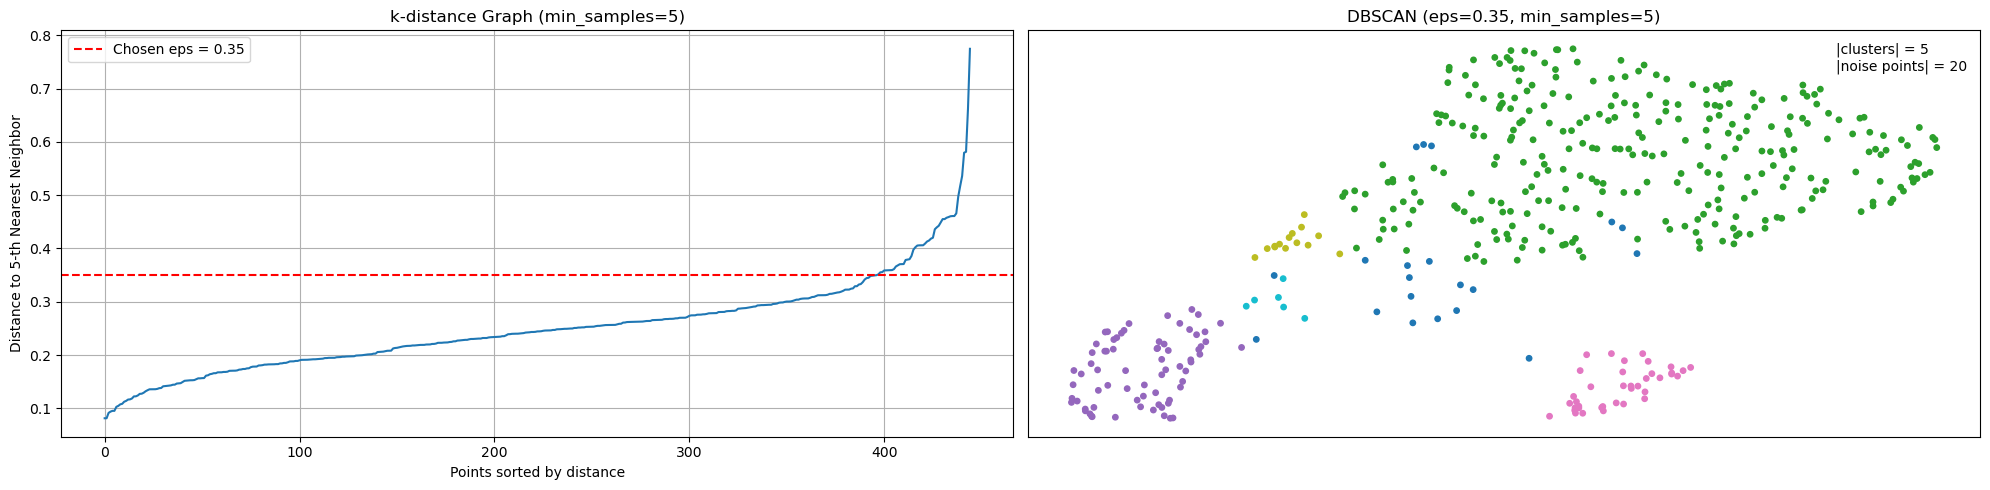

In [6]:
min_samples = 5  # typically valid in 2D embedding

# Compute distance to the k-th nearest neighbor for every point
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_umap)
distances, indices = neighbors_fit.kneighbors(X_umap)

# Sort the distances (to find the “elbow”)
distances = np.sort(distances[:, -1])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# k-distance plot
ax[0].plot(distances)
ax[0].set_title(f"k-distance Graph (min_samples={min_samples})")
ax[0].set_xlabel("Points sorted by distance")
ax[0].set_ylabel(f"Distance to {min_samples}-th Nearest Neighbor")
ax[0].grid(True)

eps_opt = 0.35  # Based on the elbow around 0.35
ax[0].axhline(eps_opt, color='red', linestyle='--', label=f"Chosen eps = {eps_opt}")
ax[0].legend()

# DBSCAN clustering
model = DBSCAN(eps=eps_opt, min_samples=min_samples)
labels = model.fit_predict(X_umap)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

ax[1].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap="tab10", s=15)
ax[1].set_title(f"DBSCAN (eps={eps_opt}, min_samples={min_samples})")
ax[1].set_xticks([]); ax[1].set_yticks([])

# legend
info_text = f"|clusters| = {n_clusters}\n|noise points| = {n_noise}"
text_only = [Line2D([], [], linestyle='none', marker='')]  # invisible handle
ax[1].legend(text_only, [info_text], loc="best", frameon=False, handlelength=0, handletextpad=0)

plt.tight_layout()
plt.show()

# Part B

## Silhouette Score

In [7]:
## Specify
verbose_bool = False

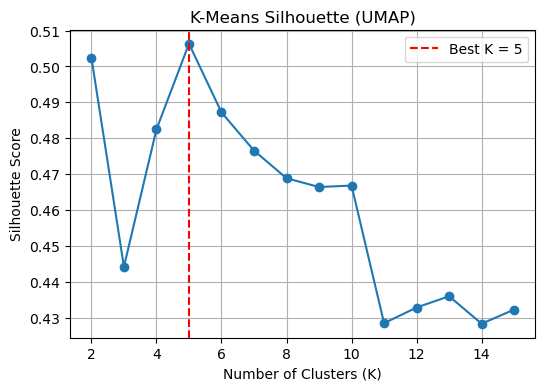

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/

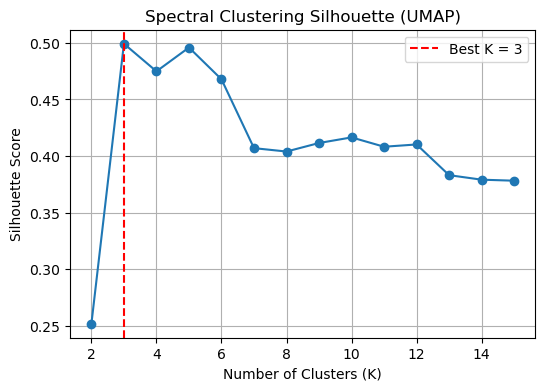

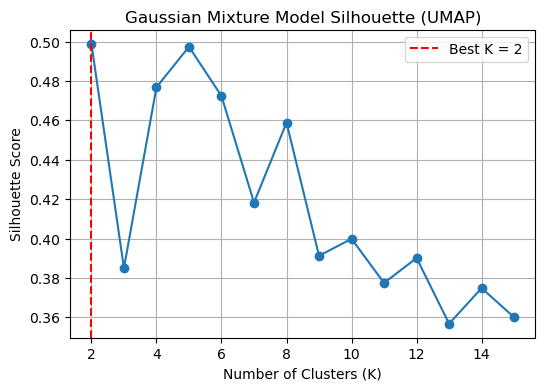

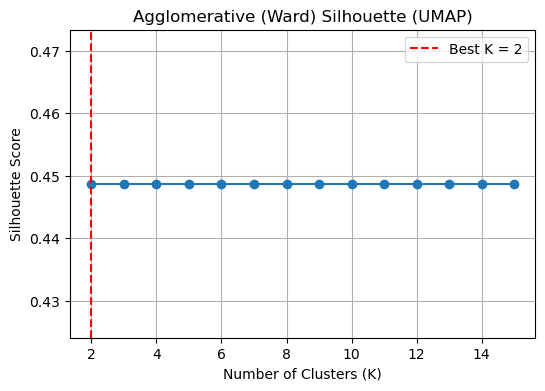

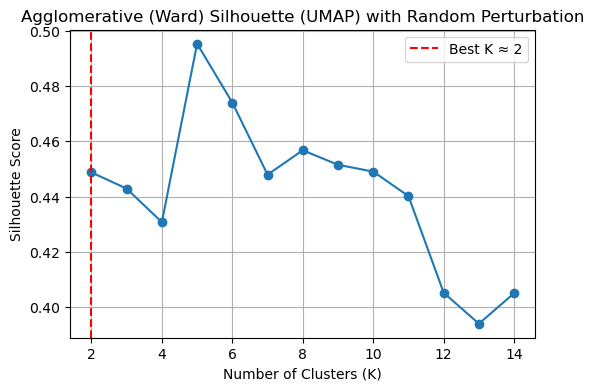

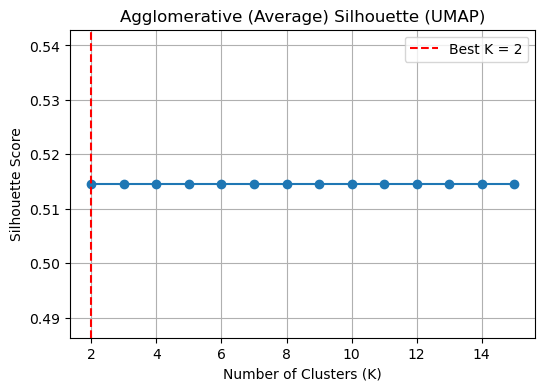

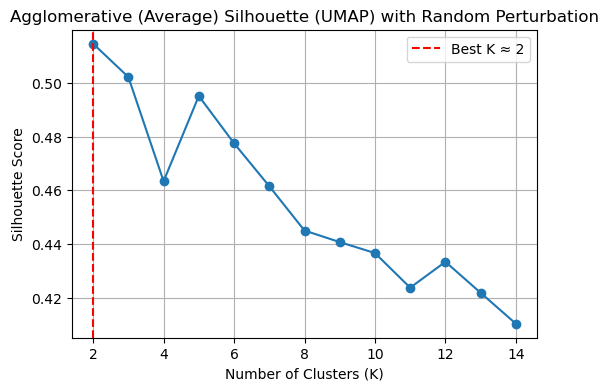

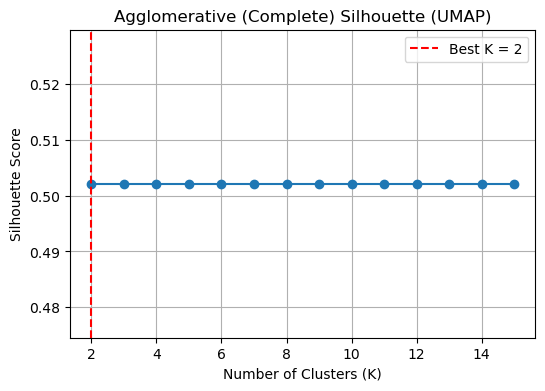

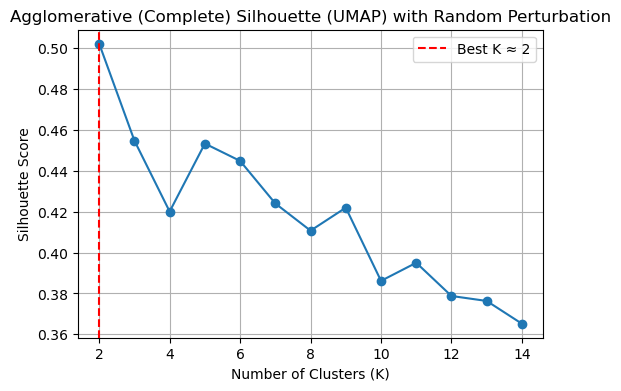

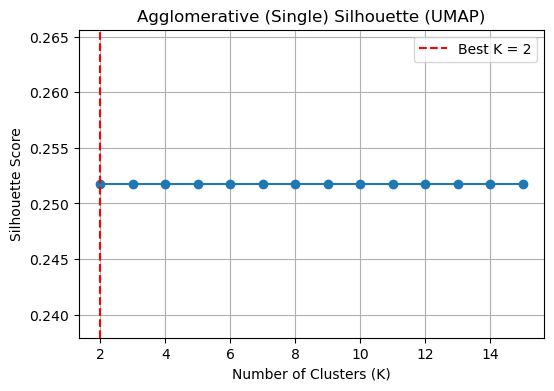

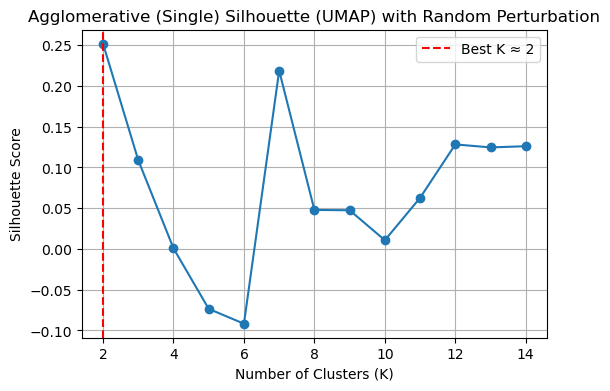

In [8]:
## Kmeans
best_k_kmeans, scores_kmeans = silhouette_analysis(
    X_umap,
    method=KMeans,
    params=dict(n_init=10),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(scores_kmeans, best_k_kmeans, title="K-Means Silhouette (UMAP)")

## Spectral
best_k_spec, scores_spec = silhouette_analysis(
    X_umap,
    method=SpectralClustering,
    params=dict(affinity="nearest_neighbors"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_spec,
    best_k_spec,
    title="Spectral Clustering Silhouette (UMAP)"
)

## GMM
best_k_gmm, scores_gmm = silhouette_analysis(
    X_umap,
    method=GaussianMixture,
    params=dict(covariance_type="full"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_gmm,
    best_k_gmm,
    title="Gaussian Mixture Model Silhouette (UMAP)"
)

## Hierarchial

for link in ["ward", "average", "complete", "single"]:
    best_k, scores = (
        silhouette_analysis(
            X_umap, 
            method=AgglomerativeClustering,
            params=dict(linkage=link),
            random_state=random_state,
            verbose=verbose_bool
        )
    )
    plot_silhouette(scores, best_k, title=f"Agglomerative ({link.capitalize()}) Silhouette (UMAP)")
    agglomerative_jitter_silhouette_scores(X_umap, random_state, link)

Best cut height t* = 0.1463 | silhouette = 0.2978 | K = 209


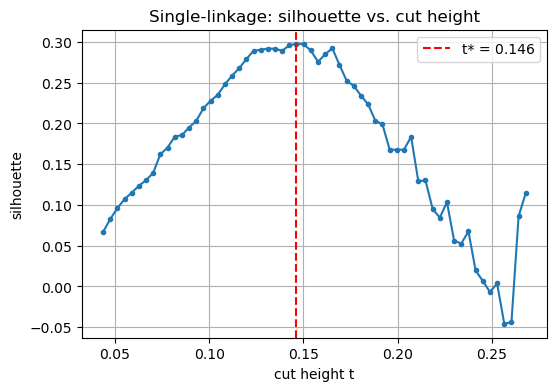

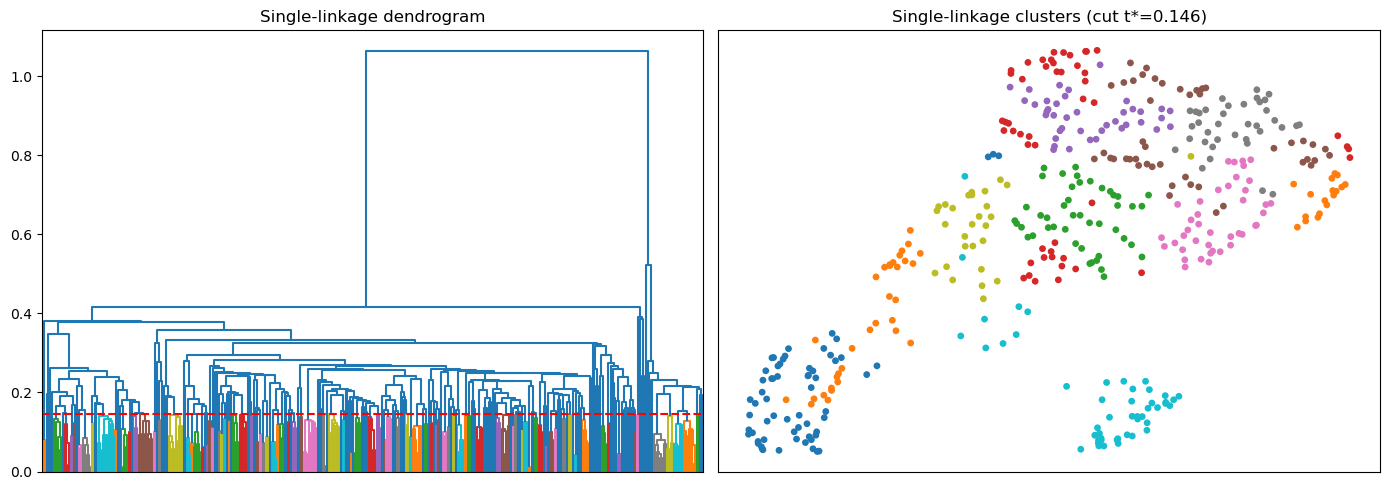

In [9]:
# --- run it on UMAP embedding ---
Z, ts, sc, best = single_linkage_best_cut(X_umap, metric="euclidean")
best_t, best_s, best_labels = best
print(f"Best cut height t* = {best_t:.4f} | silhouette = {best_s:.4f} | K = {len(np.unique(best_labels))}")

# plot silhouette over cut heights
plt.figure(figsize=(6,4))
plt.plot(ts, sc, marker='o', ms=3)
plt.axvline(best_t, color='red', ls='--', label=f"t* = {best_t:.3f}")
plt.title("Single-linkage: silhouette vs. cut height")
plt.xlabel("cut height t")
plt.ylabel("silhouette")
plt.grid(True); plt.legend(); plt.show()

# dendrogram + scatter with chosen cut
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
dendrogram(Z, no_labels=True, color_threshold=best_t, ax=ax[0])
ax[0].axhline(best_t, color='red', ls='--'); ax[0].set_title("Single-linkage dendrogram")

ax[1].scatter(X_umap[:,0], X_umap[:,1], c=best_labels, cmap="tab10", s=15)
ax[1].set_title(f"Single-linkage clusters (cut t*={best_t:.3f})"); ax[1].set_xticks([]); ax[1].set_yticks([])
plt.tight_layout(); plt.show()


In [10]:
# DBSCAN Silhouette score
res = dbscan_silhouette(X_umap, eps=0.35, min_samples=5)
print(f"silhouette={res['score']:.4f} | clusters={res['n_clusters']} | noise={res['n_noise']}")

silhouette=0.3881 | clusters=5 | noise=20


## Stability

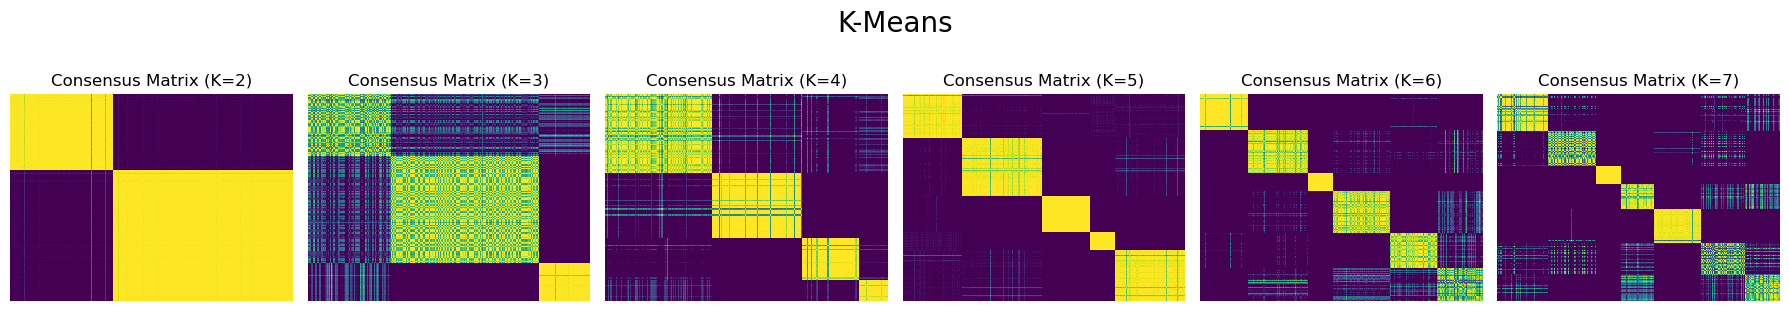

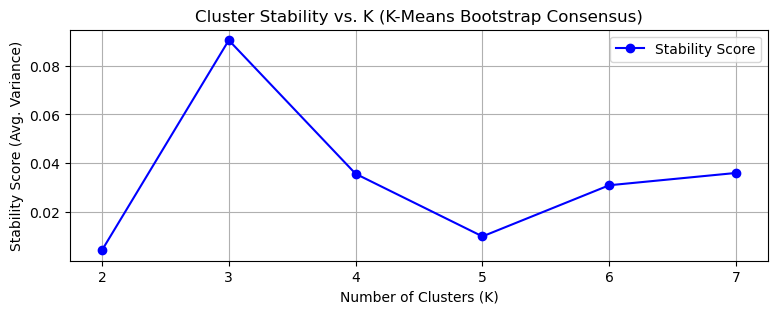

In [11]:
consensus_matrix_kmeans(
    data=X_umap,
    K_values=[2, 3, 4, 5, 6, 7],
    iterations=100,
    random_state=random_state
)

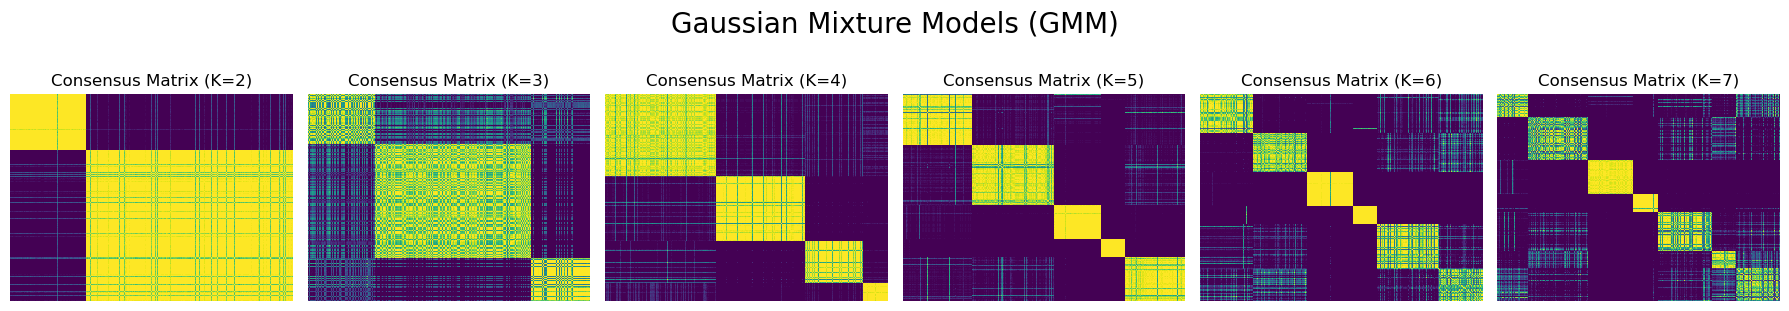

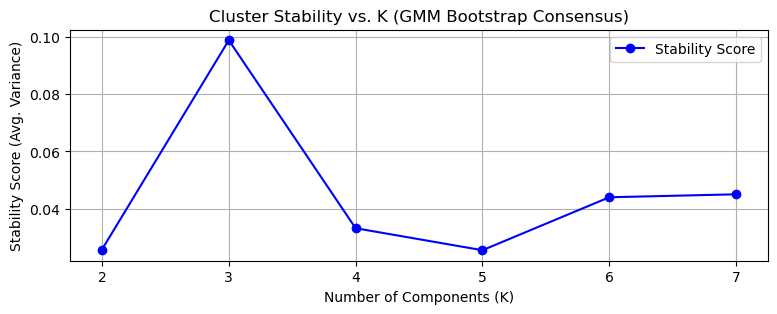

In [12]:
consensus_matrix_gmm(
    data=X_umap,
    K_values=[2, 3, 4, 5, 6, 7],
    iterations=100,
    random_state=random_state
)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/

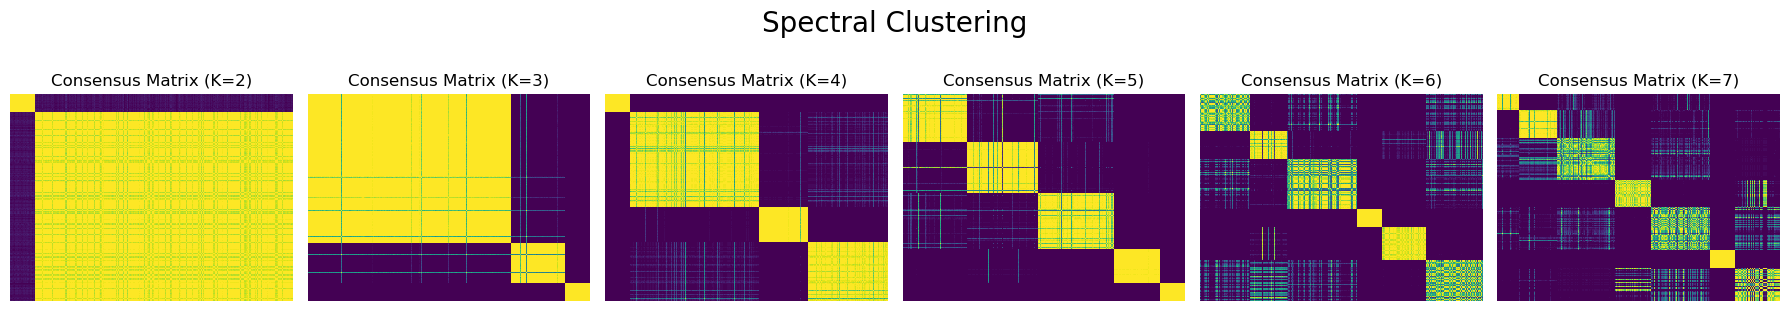

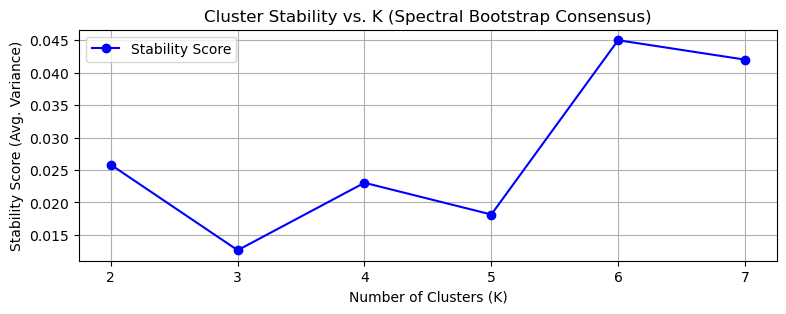

In [13]:
consensus_matrix_spectral(
    data=X_umap,
    K_values=[2, 3, 4, 5, 6, 7],
    iterations=100,
    random_state=random_state
)

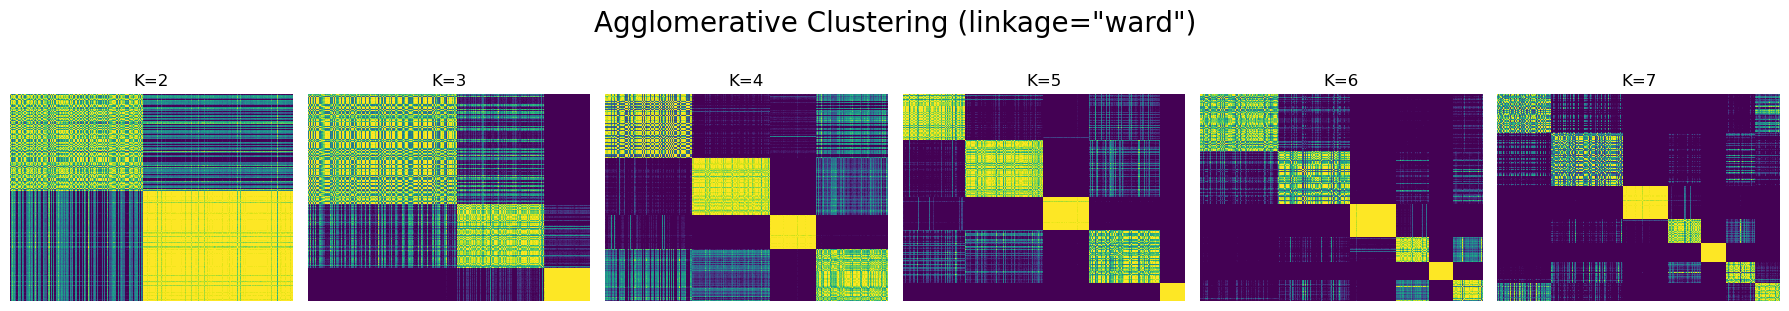

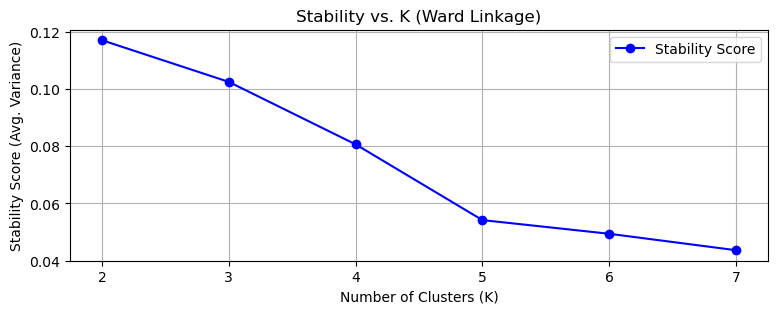

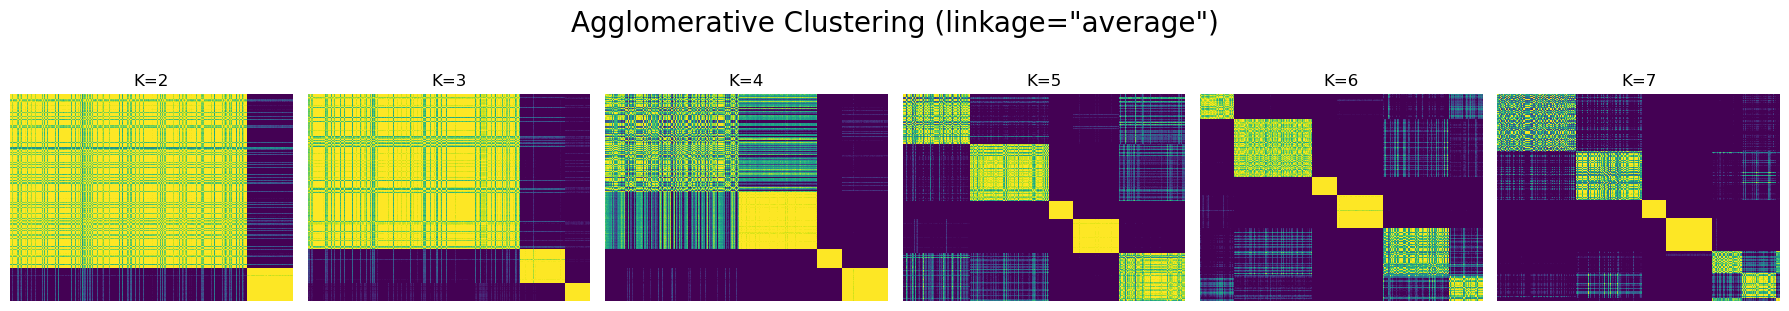

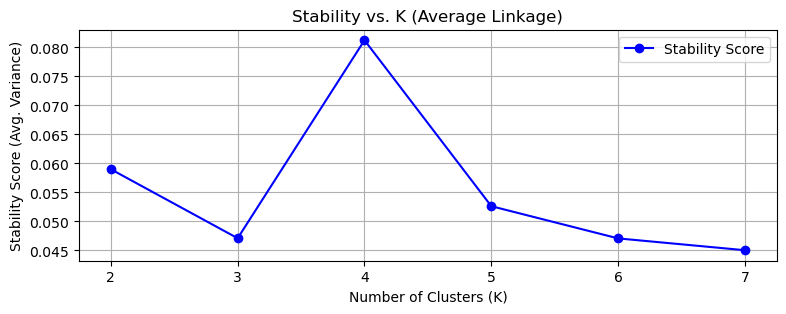

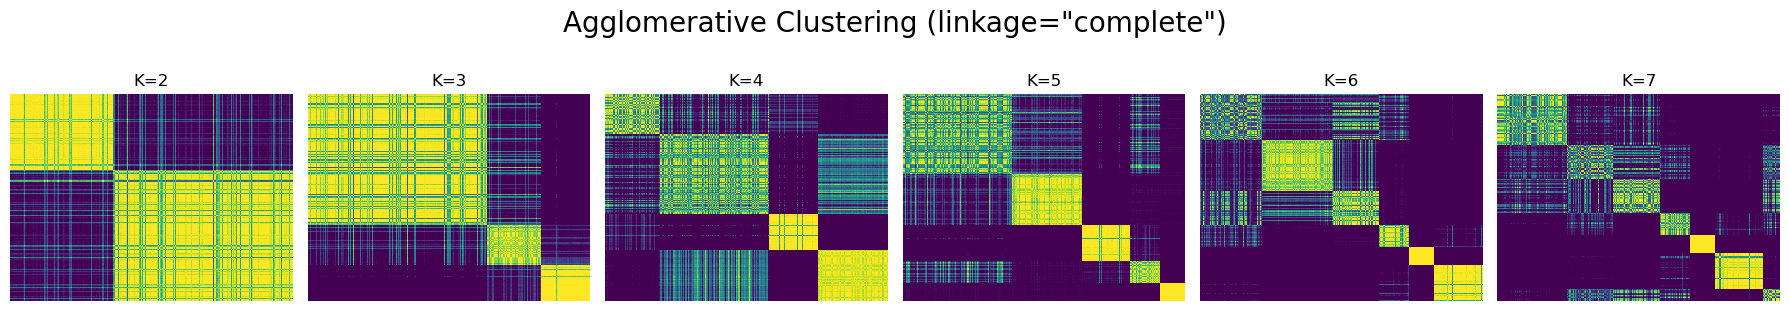

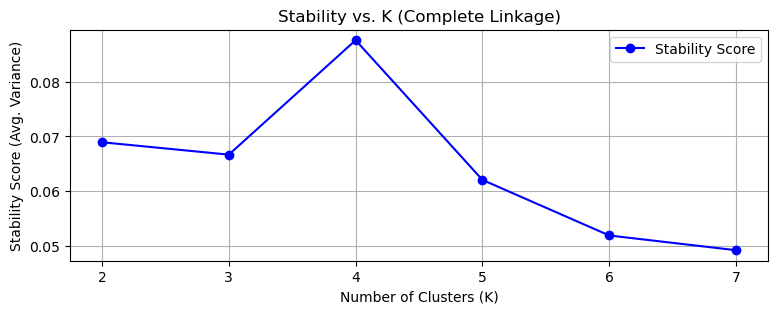

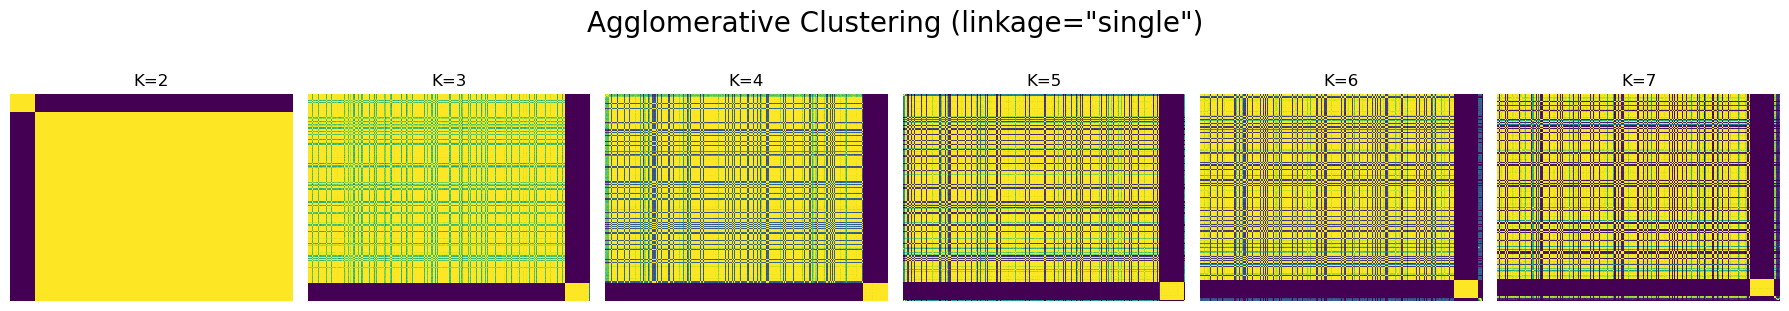

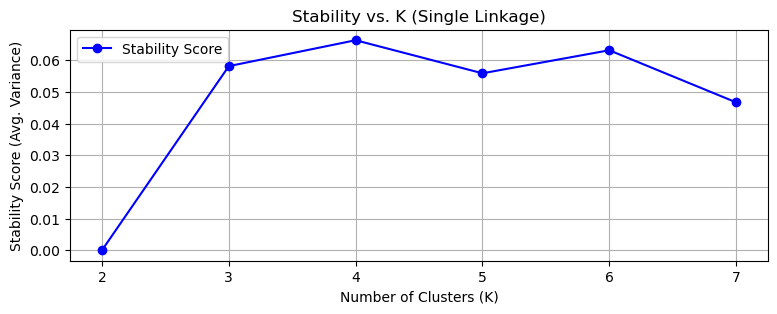

In [14]:
consensus_matrix_hierarchical(X_umap, linkage="ward")
consensus_matrix_hierarchical(X_umap, linkage="average")
consensus_matrix_hierarchical(X_umap, linkage="complete")
consensus_matrix_hierarchical(X_umap, linkage="single")

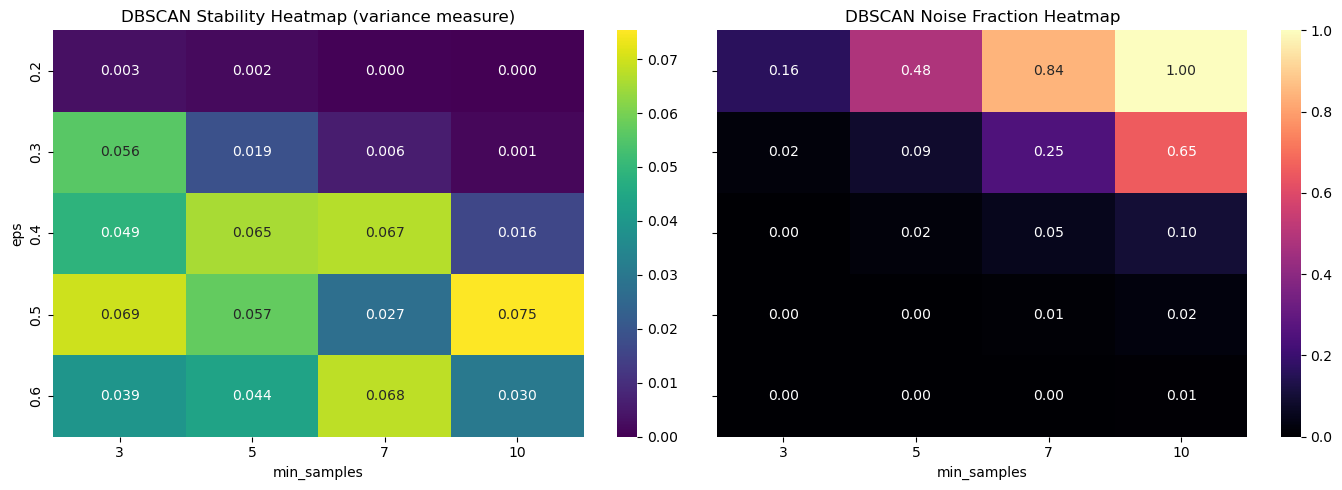

In [15]:
eps_values = np.linspace(0.2, 0.6, 5)   # range of eps values
min_samples_values = [3, 5, 7, 10]      # range of min_samples

dbscan_stability_grid(X_umap, eps_values, min_samples_values, iterations=50)

## Generalizibility

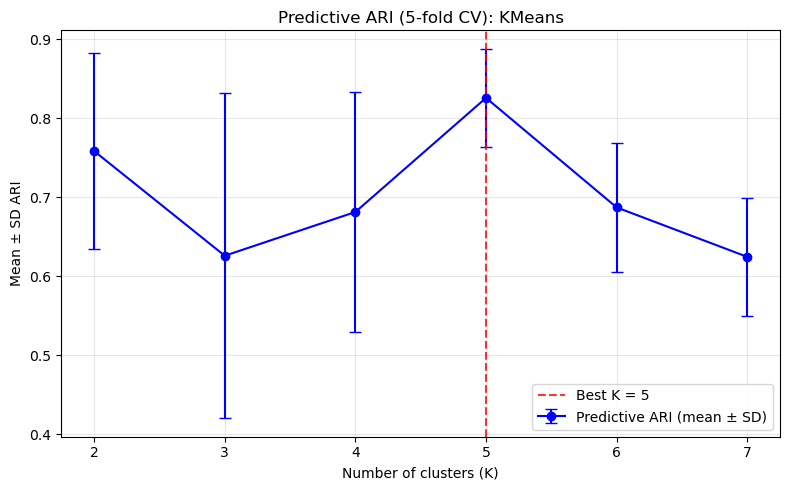

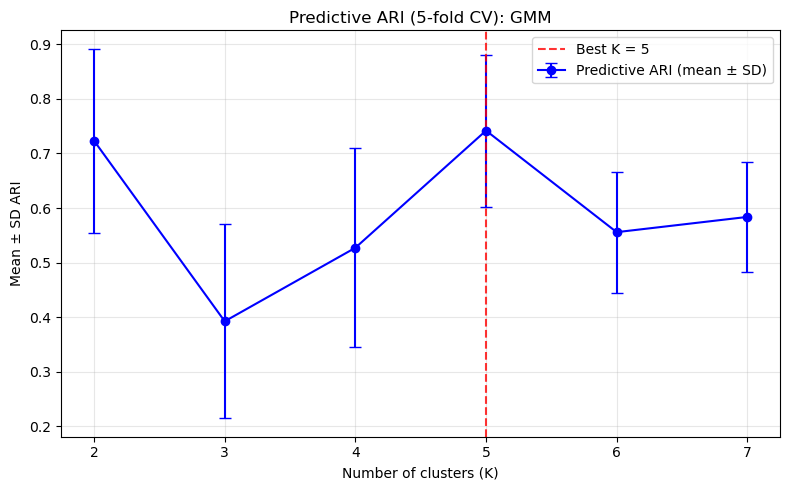

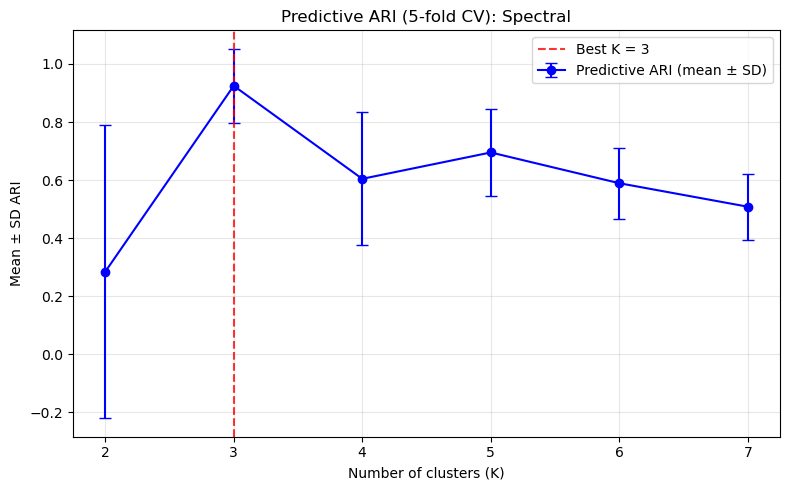

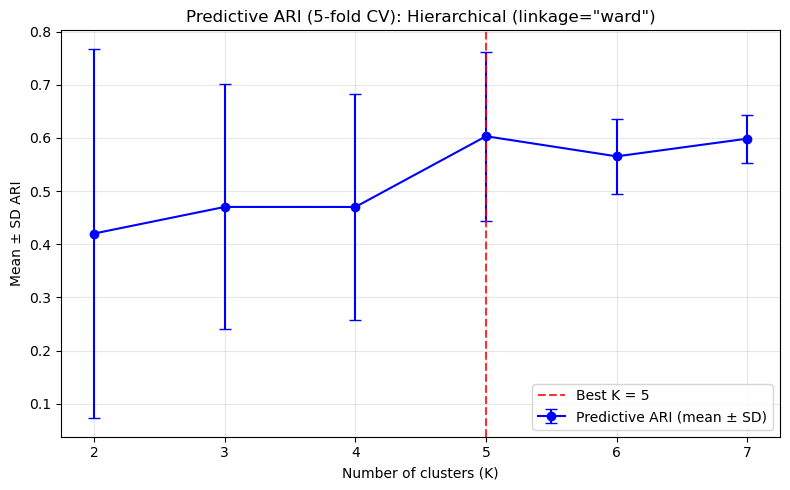

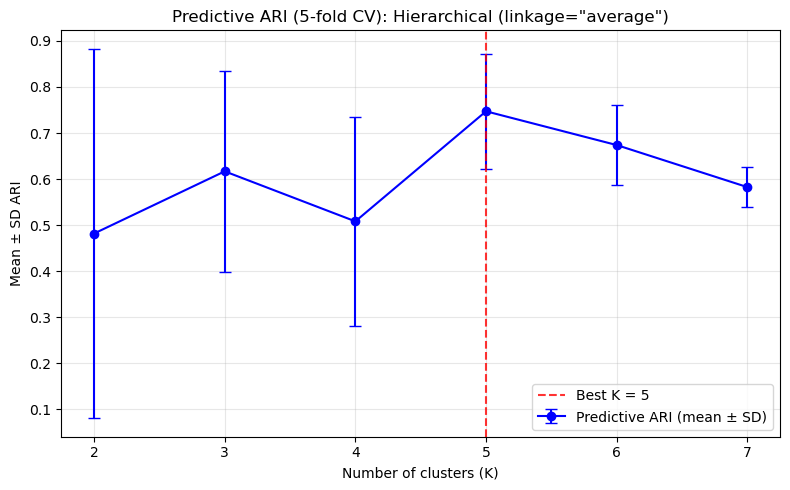

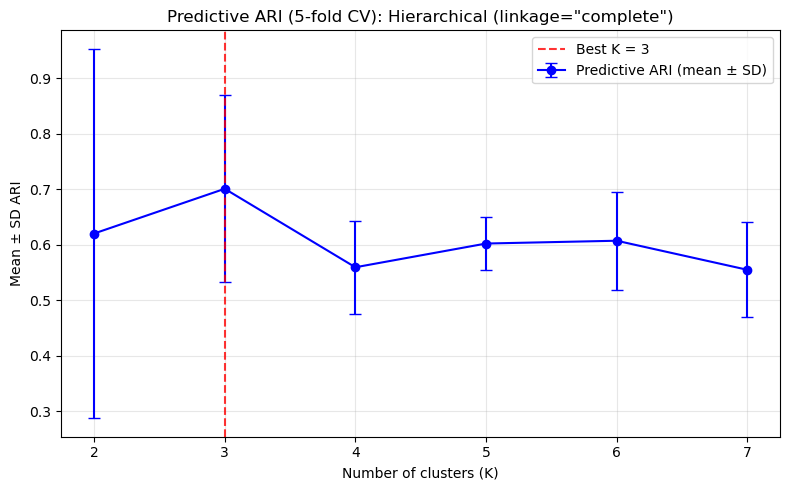

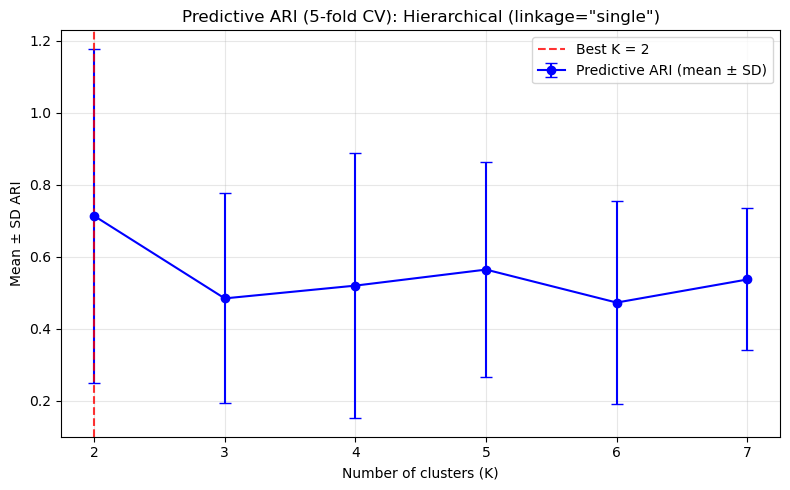

In [16]:
k_values = [2, 3, 4, 5, 6, 7]
best_k_kmeans, means_kmeans, stds_kmeans = predictive_ari_cv(X_umap, "KMeans", k_values)
best_k_gmm, means_gmm, stds_gmm = predictive_ari_cv(X_umap, "GMM", k_values)
best_k_spectral, means_spectral, stds_spectral = predictive_ari_cv(X_umap, "Spectral", k_values)
best_k_hier, means_hier, stds_hier = predictive_ari_cv(X_umap, "Hierarchical", k_values, linkage="ward")
best_k_hier, means_hier, stds_hier = predictive_ari_cv(X_umap, "Hierarchical", k_values, linkage="average")
best_k_hier, means_hier, stds_hier = predictive_ari_cv(X_umap, "Hierarchical", k_values, linkage="complete")
best_k_hier, means_hier, stds_hier = predictive_ari_cv(X_umap, "Hierarchical", k_values, linkage="single")

eps=0.25, min_samples= 3 | mean ARI=0.011
eps=0.25, min_samples= 5 | mean ARI=0.006
eps=0.25, min_samples= 7 | mean ARI=nan
eps=0.25, min_samples=10 | mean ARI=nan
eps=0.32, min_samples= 3 | mean ARI=0.062
eps=0.32, min_samples= 5 | mean ARI=-0.013
eps=0.32, min_samples= 7 | mean ARI=nan
eps=0.32, min_samples=10 | mean ARI=nan
eps=0.39, min_samples= 3 | mean ARI=0.112
eps=0.39, min_samples= 5 | mean ARI=0.042
eps=0.39, min_samples= 7 | mean ARI=0.089
eps=0.39, min_samples=10 | mean ARI=nan
eps=0.46, min_samples= 3 | mean ARI=0.108
eps=0.46, min_samples= 5 | mean ARI=0.076
eps=0.46, min_samples= 7 | mean ARI=0.001
eps=0.46, min_samples=10 | mean ARI=0.010
eps=0.53, min_samples= 3 | mean ARI=0.045
eps=0.53, min_samples= 5 | mean ARI=0.128
eps=0.53, min_samples= 7 | mean ARI=0.092
eps=0.53, min_samples=10 | mean ARI=0.070
eps=0.60, min_samples= 3 | mean ARI=0.082
eps=0.60, min_samples= 5 | mean ARI=0.056
eps=0.60, min_samples= 7 | mean ARI=0.013
eps=0.60, min_samples=10 | mean ARI=0.075


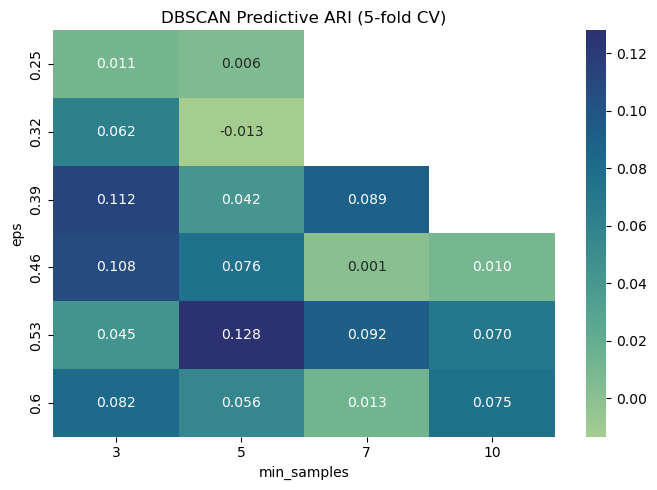


Best Parameters: eps=0.530, min_samples=5 (Mean ARI=0.128)


In [17]:
eps_values = np.linspace(0.25, 0.6, 6)
min_samples_values = [3, 5, 7, 10]
best_eps, best_ms, ari_grid = predictive_ari_dbscan(X_umap, eps_values, min_samples_values)